# Multinomial Regression

In [1]:
import arviz as az
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import bambi as bmb
import seaborn as sns

import logging

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False

logging.getLogger('matplotlib.font_manager').disabled = True  # remove warning Font family 'Arial' not found.

# Estonian dataset
* for each stratum find its intentional vote
* strata- (age_group, education, gender, nationality, electoral_district, unit)
    * unit- a sub-region in the electoral_district
* 11 different parties

## Data Aggregation
* aggregate dataset for each combination of (observed) age_group, education, gender, and nationality

In [3]:
estonian_df = pd.read_csv("../data/estonian-data.csv")
print(estonian_df.shape)
estonian_df.head()

(5206, 17)


age_group        education gender nationality  \
0     16-24  Basic education   Male    Estonian   
1     16-24  Basic education   Male    Estonian   
2     16-24  Basic education   Male    Estonian   
3     16-24  Basic education   Male    Estonian   
4     16-24  Basic education   Male    Estonian   

                      electoral_district       unit  EKRE  Eesti 200  \
0  Haabersti, Põhja-Tallinn ja Kristiine  Kristiine     0          0   
1                     Harju- ja Raplamaa   Harjumaa     0          0   
2                     Harju- ja Raplamaa   Harjumaa     0          0   
3                     Harju- ja Raplamaa   Harjumaa     1          0   
4                     Harju- ja Raplamaa   Harjumaa     0          0   

   Hard to say  Isamaa  Keskerakond  Mitte ükski erakond  Other  Parempoolsed  \
0            0       0            0                    1      0             0   
1            0       0            0                    0      0             0   
2            0       0            0                    0      0             0   
3            0       0            0                    0      0             0   
4            0       0            1                    0      0             0   

   Reformierakond  Rohelised  SDE  
0               0          0    0  
1               1          0    0  
2               0          0    1  
3               0          0    0  
4               0          0    0

In [4]:
# all parties are capitalized
PARTIES = estonian_df.columns[estonian_df.columns.str.contains("[A-Z]")].tolist()
# all other features are categorical (and not capitalizaed)
grouped_features = estonian_df.columns[~estonian_df.columns.str.contains("[A-Z]")].tolist()

In [5]:
grouped_features

['age_group',
 'education',
 'gender',
 'nationality',
 'electoral_district',
 'unit']

In [6]:
aggregated_estonian = estonian_df.groupby(grouped_features, observed=True, as_index=False).sum()
aggregated_estonian["N"] = estonian_df.groupby(grouped_features, observed=True).size().values
aggregated_estonian.head()

age_group        education  gender nationality  \
0     16-24  Basic education  Female    Estonian   
1     16-24  Basic education  Female    Estonian   
2     16-24  Basic education  Female    Estonian   
3     16-24  Basic education  Female    Estonian   
4     16-24  Basic education  Female    Estonian   

                      electoral_district       unit  EKRE  Eesti 200  \
0  Haabersti, Põhja-Tallinn ja Kristiine  Haabersti     0          1   
1  Haabersti, Põhja-Tallinn ja Kristiine  Kristiine     0          4   
2                     Harju- ja Raplamaa   Harjumaa     1          0   
3              Hiiu-, Lääne- ja Saaremaa    Hiiumaa     0          0   
4              Hiiu-, Lääne- ja Saaremaa   Läänemaa     0          0   

   Hard to say  Isamaa  Keskerakond  Mitte ükski erakond  Other  Parempoolsed  \
0            0       0            0                    0      0             0   
1            0       0            0                    0      0             0   
2            2       0            0                    0      0             0   
3            1       0            0                    0      0             0   
4            0       0            0                    0      0             0   

   Reformierakond  Rohelised  SDE  N  
0               1          0    0  2  
1               0          0    1  5  
2               0          0    1  4  
3               0          0    0  1  
4               1          0    0  1

In [7]:
# extract categorical indexes and values
age_group_idx, age_groups = aggregated_estonian["age_group"].factorize(sort=True)
education_idx, educations = aggregated_estonian["education"].factorize(sort=True)
gender_idx, genders = aggregated_estonian["gender"].factorize(sort=True)
nationality_idx, nationalities = aggregated_estonian["nationality"].factorize(sort=True)
unit_idx, units = aggregated_estonian["unit"].factorize(sort=True)

# aggregate feature (map unit to its electoral district)
electoral_district_idx, electoral_districts = (
    aggregated_estonian
        .groupby(["electoral_district", "unit"], observed=True, as_index=False)
        .size()
        ["electoral_district"]
        .factorize(sort=True)
)

In [8]:
agg_coords = {
    "age_group": age_groups,
    "education": educations,
    "gender": genders,
    "nationality": nationalities,
    "unit": units,
    "electoral_district": electoral_districts,
    "party": PARTIES,
    "obs_idx": aggregated_estonian.index
}

In [9]:
with pm.Model(coords=agg_coords) as multinomial_model:
    # data
    age_group_id = pm.MutableData("age_group_id", age_group_idx, dims="obs_idx")
    education_id = pm.MutableData("education_id", education_idx, dims="obs_idx")
    gender_id = pm.MutableData("gender_id", gender_idx, dims="obs_idx")
    nationality_id = pm.MutableData("nationality_id", nationality_idx, dims="obs_idx")
    unit_id = pm.MutableData("unit_id", unit_idx, dims="obs_idx")
    electoral_district_id = pm.MutableData("electoral_district_id", electoral_district_idx, dims="unit")
    
    observed = pm.MutableData("observed", aggregated_estonian[PARTIES], dims=("obs_idx", "party"))
    N = pm.MutableData("N", aggregated_estonian["N"], dims="obs_idx")
    
    # parameters
    baseline = pm.ZeroSumNormal("baseline", dims="party")
    β_age = pm.ZeroSumNormal("β_age", dims=("age_group", "party"), zerosum_axes=2)
    β_education = pm.ZeroSumNormal("β_education", dims=("education", "party"), zerosum_axes=2)
    β_gender = pm.ZeroSumNormal("β_gender", dims=("gender", "party"), zerosum_axes=2)
    β_nationality = pm.ZeroSumNormal("β_nationality", dims=("nationality", "party"), zerosum_axes=2)
    β_gender_nat = pm.ZeroSumNormal("β_gender_nat", dims=("gender", "nationality", "party"), zerosum_axes=3)
    # unit- hierarchical feature (composed of global behavior (electoral district) and offset (unit))
    β_electoral_district = pm.ZeroSumNormal(
        "β_electoral_district",
        dims=("electoral_district", "party"),
        zerosum_axes=2,
    )  # β_electoral_district[electoral_districts_id] dim=("unit", "party")
    β_unit_offset = pm.ZeroSumNormal("β_unit_offset", dims=("unit", "party"), zerosum_axes=2)
    β_unit = pm.Deterministic(
        "β_unit",
        β_electoral_district[electoral_district_id] + β_unit_offset,  #  
        dims=("unit", "party"),
    )
    # dims=(obs_idx, party)
    η = (baseline[None] + 
         β_age[age_group_id] + β_education[education_id] + β_gender[gender_id] +
         β_nationality[nationality_id] + β_gender_nat[gender_id, nationality_id] + 
         β_unit[unit_id] 
        )
    # dims=(obs_idx, party)
    p = pm.math.softmax(η, axis=-1)
    assert np.allclose(p.eval().sum(axis=1), np.ones(len(age_group_idx))), "probabilties don't sum to 1"
    
    print(f"baseline shape= {baseline.eval().shape}")
    print(f"β_electoral_district shape= {β_electoral_district.eval().shape}")
    print(f"β_electoral_district[electoral_districts_id] shape= {β_electoral_district[electoral_district_id].eval().shape}")
    print(f"β_unit_offset shape= {β_unit_offset.eval().shape}")
    print(f"β_gender_nat shape= {β_gender_nat.eval().shape}")
    print(f"η shape= {η.eval().shape}")
    print(f"p shape= {p.eval().shape}")
    
    # likelihood
    pm.Multinomial("y", n=N, p=p, observed=observed, dims=("obs_idx", "party"))

baseline shape= (11,)
β_electoral_district shape= (12, 11)
β_electoral_district[electoral_districts_id] shape= (24, 11)
β_unit_offset shape= (24, 11)
β_gender_nat shape= (2, 2, 11)
η shape= (1157, 11)
p shape= (1157, 11)


In [10]:
with multinomial_model:
    multinomial_idata = pm.sample(chains=4, random_seed=1234)
    multinomial_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(multinomial_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [baseline, β_age, β_education, β_gender, β_nationality, β_gender_nat, β_electoral_district, β_unit_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1318 seconds.
Sampling: [baseline, y, β_age, β_education, β_electoral_district, β_gender, β_gender_nat, β_nationality, β_unit_offset]
Sampling: [y]


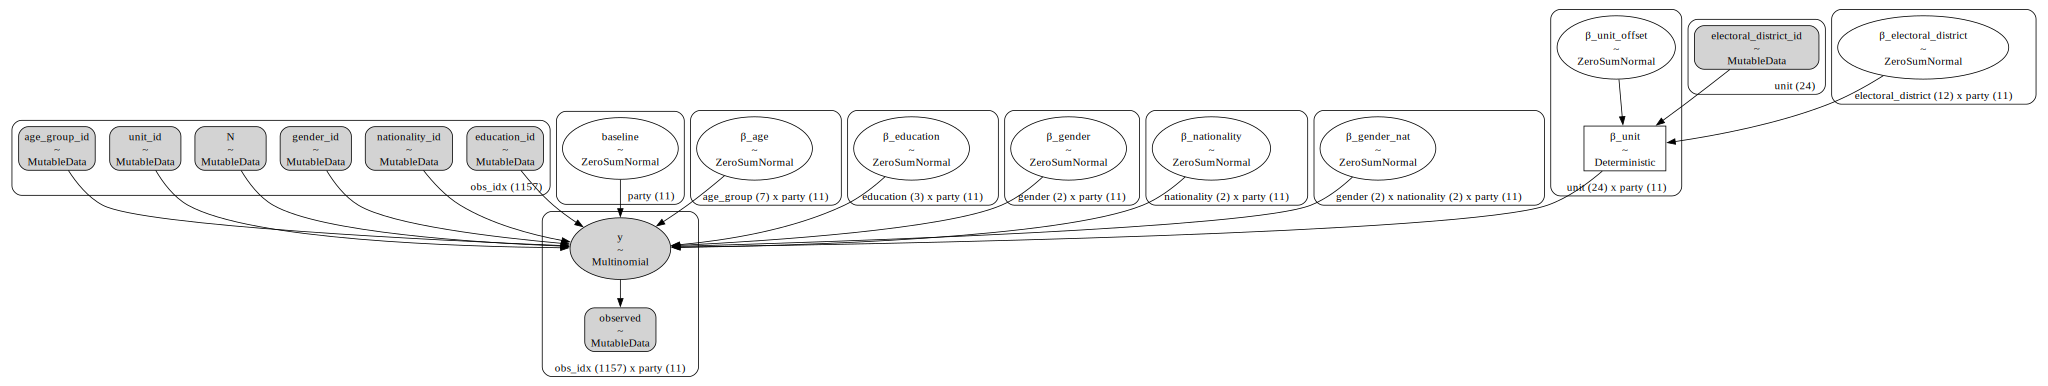

In [11]:
pm.model_to_graphviz(multinomial_model)

In [12]:
# save inference data
az.to_netcdf(multinomial_idata, "../models/multinomial_pymc_idata.nc")

'../models/multinomial_pymc_idata.nc'

### Bambi Model

In [13]:
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)

In [14]:
aggregated_bmb_estonian = aggregated_estonian.copy()
aggregated_bmb_estonian.columns = [col.replace(" ", "_") for col in aggregated_bmb_estonian.columns]
aggregated_bmb_estonian

age_group            education  gender nationality  \
0        16-24      Basic education  Female    Estonian   
1        16-24      Basic education  Female    Estonian   
2        16-24      Basic education  Female    Estonian   
3        16-24      Basic education  Female    Estonian   
4        16-24      Basic education  Female    Estonian   
...        ...                  ...     ...         ...   
1152       75+  Secondary education    Male       Other   
1153       75+  Secondary education    Male       Other   
1154       75+  Secondary education    Male       Other   
1155       75+  Secondary education    Male       Other   
1156       75+  Secondary education    Male       Other   

                         electoral_district           unit  EKRE  Eesti_200  \
0     Haabersti, Põhja-Tallinn ja Kristiine      Haabersti     0          1   
1     Haabersti, Põhja-Tallinn ja Kristiine      Kristiine     0          4   
2                        Harju- ja Raplamaa       Harjumaa     1          0   
3                 Hiiu-, Lääne- ja Saaremaa        Hiiumaa     0          0   
4                 Hiiu-, Lääne- ja Saaremaa       Läänemaa     0          0   
...                                     ...            ...   ...        ...   
1152  Haabersti, Põhja-Tallinn ja Kristiine  Põhja-Tallinn     0          0   
1153                     Harju- ja Raplamaa       Harjumaa     0          1   
1154              Hiiu-, Lääne- ja Saaremaa       Läänemaa     0          1   
1155                  Järva- ja Viljandimaa       Järvamaa     0          0   
1156                               Pärnumaa       Pärnumaa     0          0   

      Hard_to_say  Isamaa  Keskerakond  Mitte_ükski_erakond  Other  \
0               0       0            0                    0      0   
1               0       0            0                    0      0   
2               2       0            0                    0      0   
3               1       0            0                    0      0   
4               0       0            0                    0      0   
...           ...     ...          ...                  ...    ...   
1152            1       0            0                    0      0   
1153            0       0            0                    0      0   
1154            0       0            0                    0      0   
1155            0       0            0                    1      0   
1156            0       0            0                    1      0   

      Parempoolsed  Reformierakond  Rohelised  SDE  N  
0                0               1          0    0  2  
1                0               0          0    1  5  
2                0               0          0    1  4  
3                0               0          0    0  1  
4                0               1          0    0  1  
...            ...             ...        ...  ... ..  
1152             0               0          0    0  1  
1153             0               0          0    0  1  
1154             0               0          0    0  1  
1155             0               0          0    0  1  
1156             0               0          0    0  1  

[1157 rows x 18 columns]

In [15]:
# concatenate multiple target columns
target_formula = ", ".join([party.replace(" ", "_") for party in PARTIES])
features_formula = (
    "0 + electoral_district + unit + age_group + education + gender + nationality + gender: nationality"
)
formula = f"c({target_formula}) ~ {features_formula}"
formula

'c(EKRE, Eesti_200, Hard_to_say, Isamaa, Keskerakond, Mitte_ükski_erakond, Other, Parempoolsed, Reformierakond, Rohelised, SDE) ~ 0 + electoral_district + unit + age_group + education + gender + nationality + gender: nationality'

In [16]:
multinomial_bmb_model = bmb.Model(
    formula=formula,
    data=aggregated_bmb_estonian,
    family="multinomial",
    link="softmax"
)
multinomial_bmb_model

       Formula: c(EKRE, Eesti_200, Hard_to_say, Isamaa, Keskerakond, Mitte_ükski_erakond, Other, Parempoolsed, Reformierakond, Rohelised, SDE) ~ 0 + electoral_district + unit + age_group + education + gender + nationality + gender: nationality
        Family: multinomial
          Link: p = softmax
  Observations: 1157
        Priors: 
    target = p
        Common-level effects
            electoral_district ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma: [ 7.1495  8.6295
                9.0632 11.1867  9.6346  9.5308  7.4214 12.4138  8.666
             10.8569 10.7034  8.1996])
            unit ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma:
                [10.7034 19.1813 11.1867 13.6841 14.209  12.6638 12.5368 10.8569 12.4138
             14.209  11.0178 13.2159 13.8522 10.8569 11.1867 14.0271 13.6841 13.8522
             10.7034 12.4138 13.2159 13.0707 13.8522])
            age_group ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [

In [17]:
multinomial_bmb_model.set_priors(common=bmb.Prior("Normal", mu=0, sigma=0.2))
multinomial_bmb_model.set_alias({f"c({target_formula})": "answers"})
multinomial_bmb_model

       Formula: c(EKRE, Eesti_200, Hard_to_say, Isamaa, Keskerakond, Mitte_ükski_erakond, Other, Parempoolsed, Reformierakond, Rohelised, SDE) ~ 0 + electoral_district + unit + age_group + education + gender + nationality + gender: nationality
        Family: multinomial
          Link: p = softmax
  Observations: 1157
        Priors: 
    target = p
        Common-level effects
            electoral_district ~ Normal(mu: 0.0, sigma: 0.2)
            unit ~ Normal(mu: 0.0, sigma: 0.2)
            age_group ~ Normal(mu: 0.0, sigma: 0.2)
            education ~ Normal(mu: 0.0, sigma: 0.2)
            gender ~ Normal(mu: 0.0, sigma: 0.2)
            nationality ~ Normal(mu: 0.0, sigma: 0.2)
            gender:nationality ~ Normal(mu: 0.0, sigma: 0.2)

In [18]:
multinomial_bmb_idata = multinomial_bmb_model.fit(random_seed=RANDOM_SEED, chains=4)
multinomial_bmb_idata.extend(multinomial_bmb_model.prior_predictive(random_seed=RANDOM_SEED))
multinomial_bmb_model.predict(multinomial_bmb_idata, kind="pps")
# multinomial_bmb_model.predict(multinomial_bmb_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [electoral_district, unit, age_group, education, gender, nationality, gender:nationality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
Sampling: [age_group, answers, education, electoral_district, gender, gender:nationality, nationality, unit]


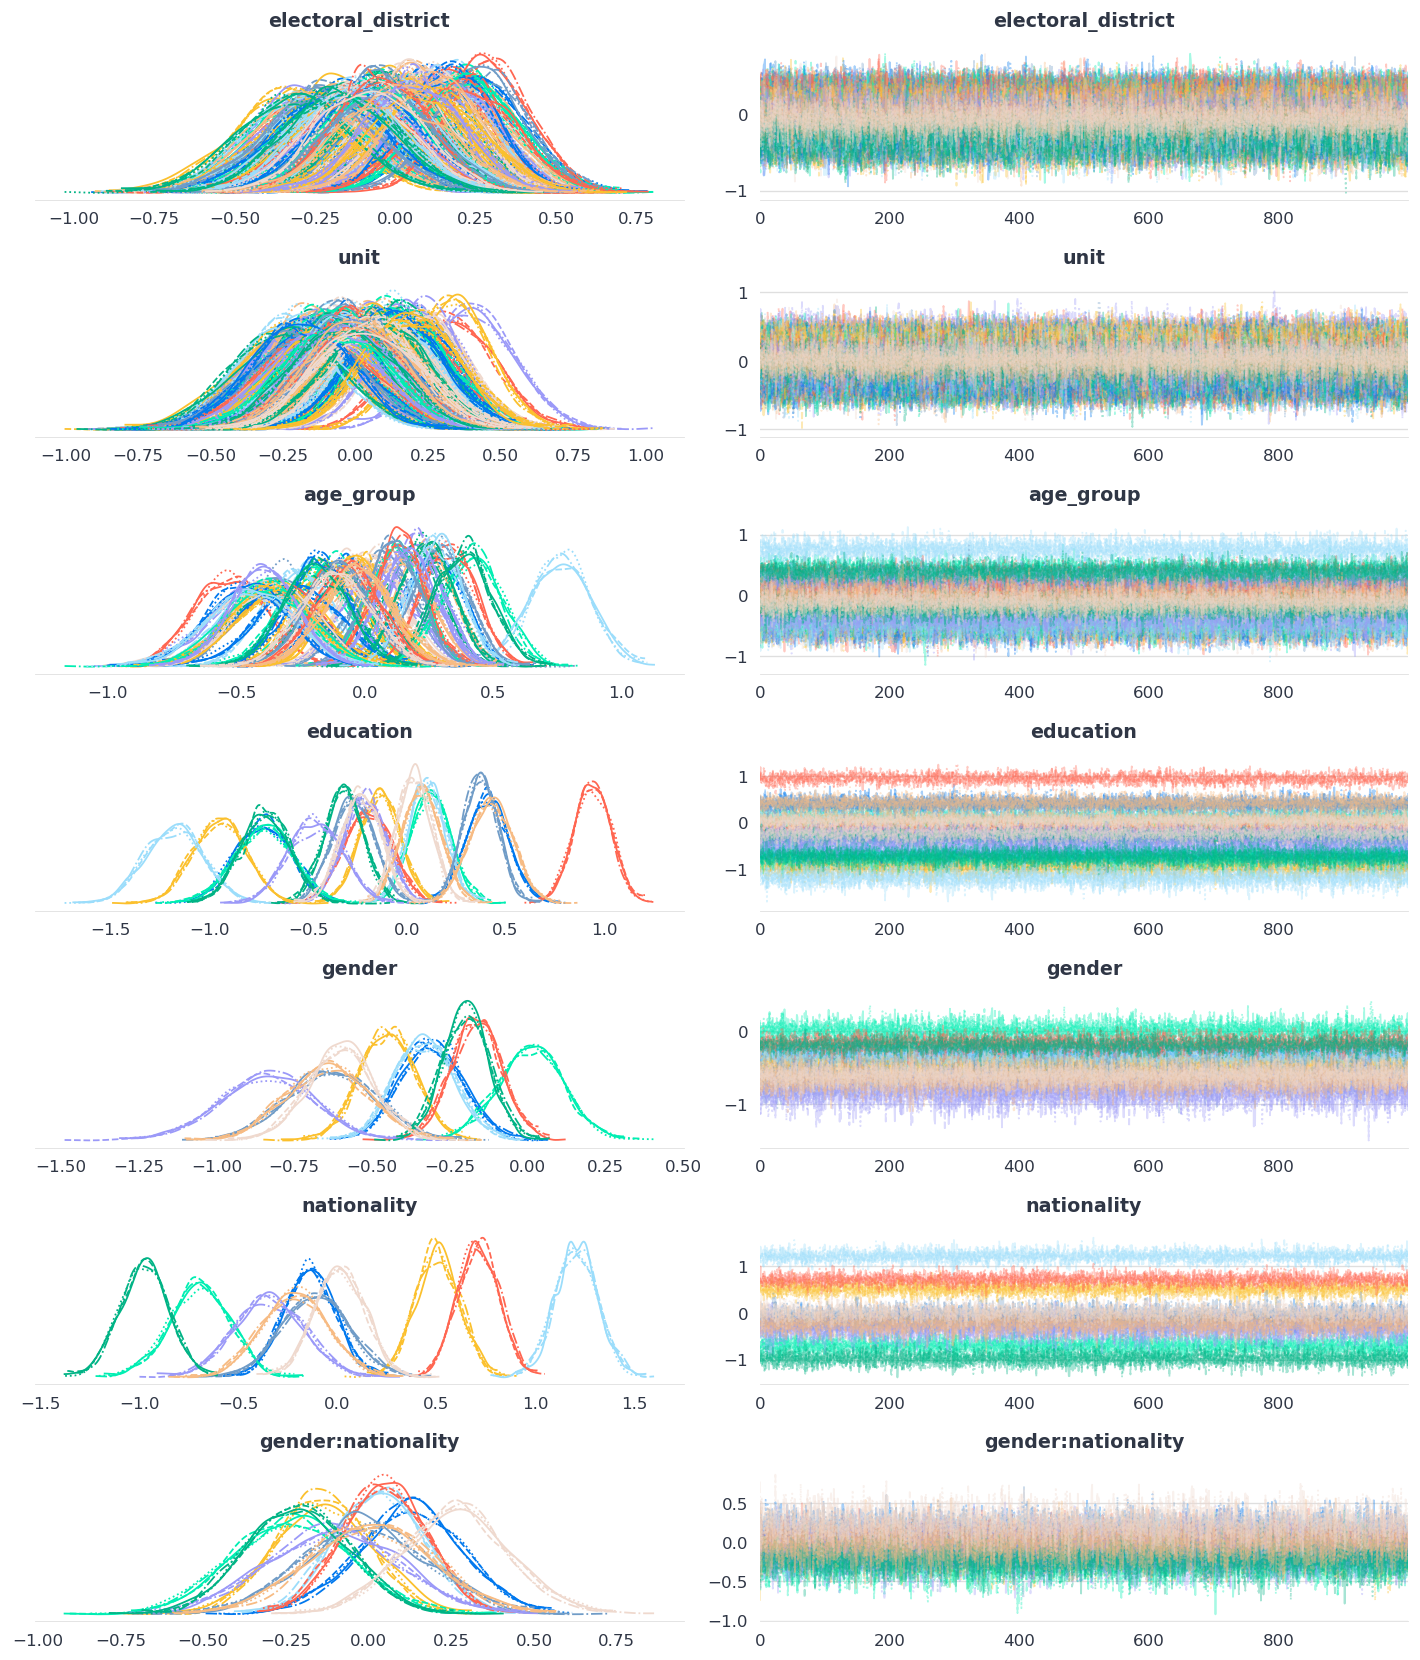

In [20]:
az.plot_trace(multinomial_bmb_idata, var_names="~answers_mean");
plt.tight_layout()
plt.show()

**2. *Check that there are 11 parties, and that the posterior mean of `baseline` across all dimensions is 0.***

In [11]:
# load data
# multinomial_idata = az.from_netcdf("../models/multinomial_pymc_idata.nc")

In [21]:
len(multinomial_idata.posterior["party"]) == 11

True

In [22]:
multinomial_idata.posterior["baseline"].mean(dim=("chain", "draw"))

<xarray.DataArray 'baseline' (party: 11)>
array([ 1.13459949,  0.45455854,  1.27530346, -0.61012702,  1.34231516,
        1.80595909, -1.76449683, -3.46808118,  0.89786162, -1.40850819,
        0.34061586])
Coordinates:
  * party    (party) <U19 'EKRE' 'Eesti 200' 'Hard to say' ... 'Rohelised' 'SDE'

In [23]:
# check that the sum/mean of the intercepts across all classes is (approx.) 0
np.allclose(multinomial_idata.posterior["baseline"].mean(), np.zeros(1))

True

In [24]:
# check that the sum/mean of the slopes across party and age_group axes are (approx.) 0 
np.allclose(
    multinomial_idata.posterior["β_age"].mean(dim=("chain", "draw")).sum(dim="age_group"),
    np.zeros(len(PARTIES))
)
np.allclose(
    multinomial_idata.posterior["β_age"].mean(dim=("chain", "draw")).sum(dim="party"),
    np.zeros(len(age_groups))
)

True

## correlation of `education` with voting preferences
* **people with basic education** have a strong preference for EKRE, Keskerakond and Mitte. In contrast, they really dislike SDE, Reformierakond and Eesti.

* **people with secondary education** don't seem to have strong preferences 

* **most educated part of the population** really _dislikes_ EKRE, Keskerakond and Mitte... and __prefers__ SDE, Reformierakond and Eesti -- the exact opposite of the lowest educated level!

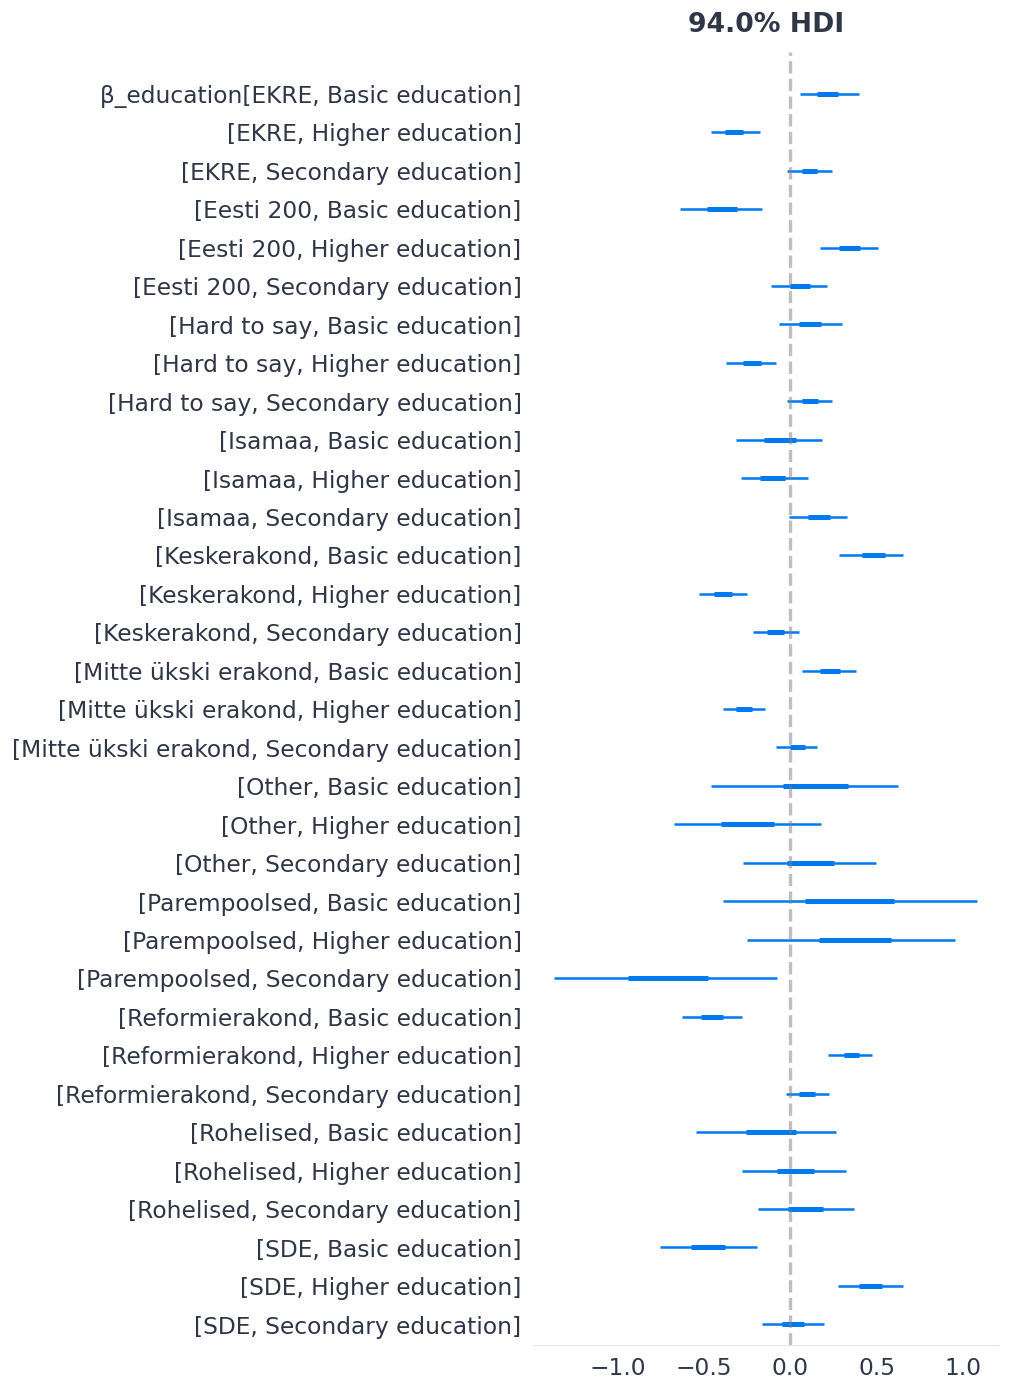

In [30]:
fig, ax = plt.subplots(figsize=(5, 14))  # , layout="constrained"
# transpose so the party dimensino is first:
# * (party, education, draw, chain) instead of (chain, draw, education, party)
az.plot_forest(
    data=multinomial_idata.posterior["β_education"].T,  
    var_names="β_education",
    combined=True,
    ax=ax
)
ax.axvline(x=0, color="grey", lw=2, ls="--", alpha=0.5,);

## correlation of `gender` with voting preferences
* heatmap of posterior medians of `β_gender`, with gender horizontally and parties vertically.


In [32]:
median_gender_df = (
    multinomial_idata
        .posterior["β_gender"]  # (chain, draw, gender, party)
        .median(dim=("chain", "draw"))
        .to_dataframe()
        .reset_index()
        .pivot(index="party", columns="gender", values="β_gender")
)

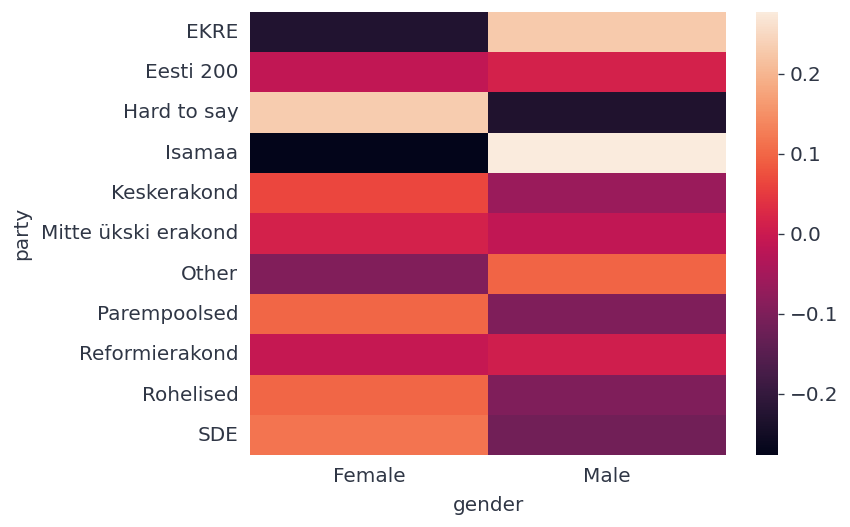

In [33]:
sns.heatmap(median_gender_df)  # cmap=sns.light_palette("#0078ee", as_cmap=True)
plt.show()

In [34]:
median_gender_df

gender                 Female      Male
party                                  
EKRE                -0.227853  0.227853
Eesti 200           -0.013944  0.013944
Hard to say          0.230905 -0.230905
Isamaa              -0.277173  0.277173
Keskerakond          0.064889 -0.064889
Mitte ükski erakond  0.013299 -0.013299
Other               -0.097351  0.097351
Parempoolsed         0.098317 -0.098317
Reformierakond      -0.007730  0.007730
Rohelised            0.098191 -0.098191
SDE                  0.116239 -0.116239

### Notes
* Males prefer EKRE, Isamaa and Other
* Females prefer SDE, Mitte ükski erakond, Parempoolsed, Rohelised
    * Females are more indecisive

### Difference between Males and Females

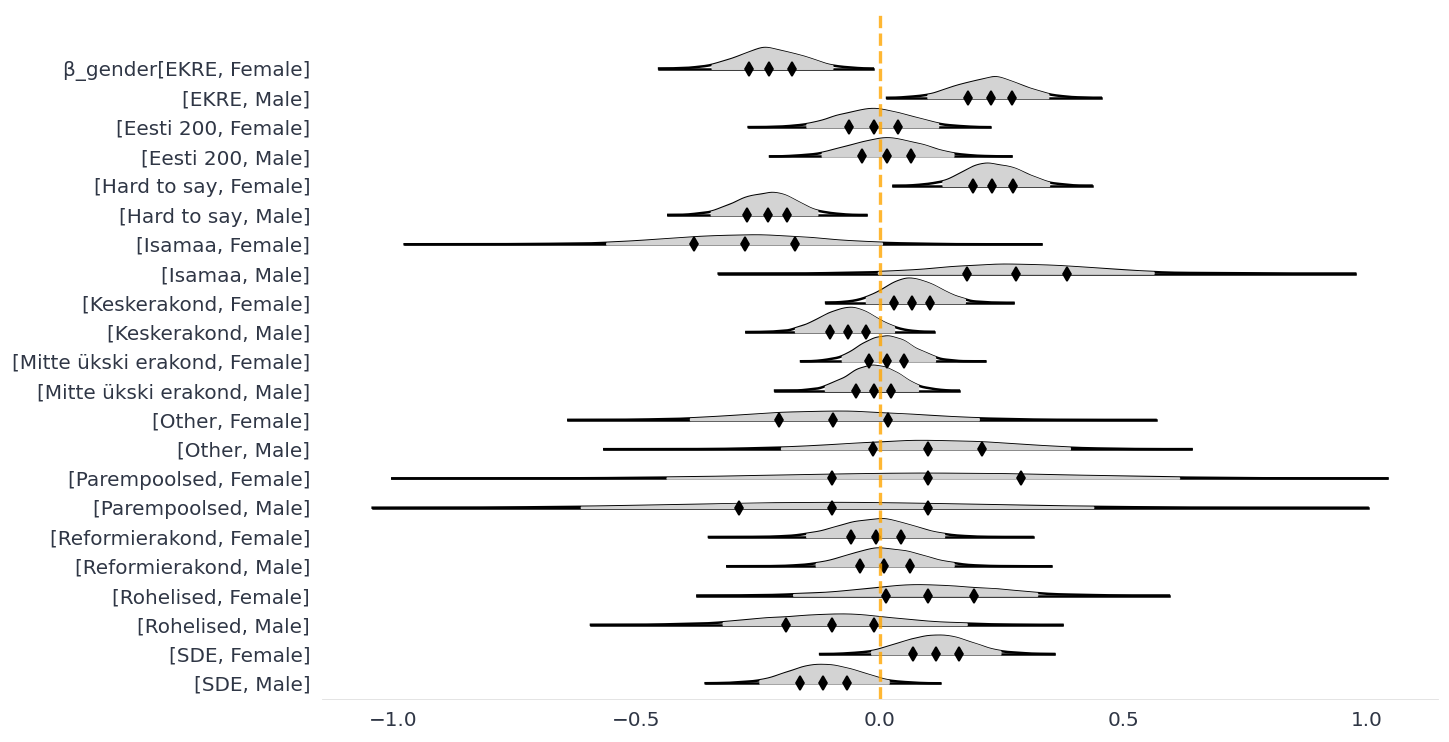

In [40]:
ax = az.plot_forest(
    multinomial_idata.posterior["β_gender"].T,
    combined=True,
    kind="ridgeplot",
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    ridgeplot_overlap=0.7,
    colors="lightgrey",
)
ax[0].axvline(ls="--", alpha=0.8, color="orange", lw=2);

In [44]:
gender_diff = (
    multinomial_idata.posterior["β_gender"].sel(gender="Male") - 
    multinomial_idata.posterior["β_gender"].sel(gender="Female")
)

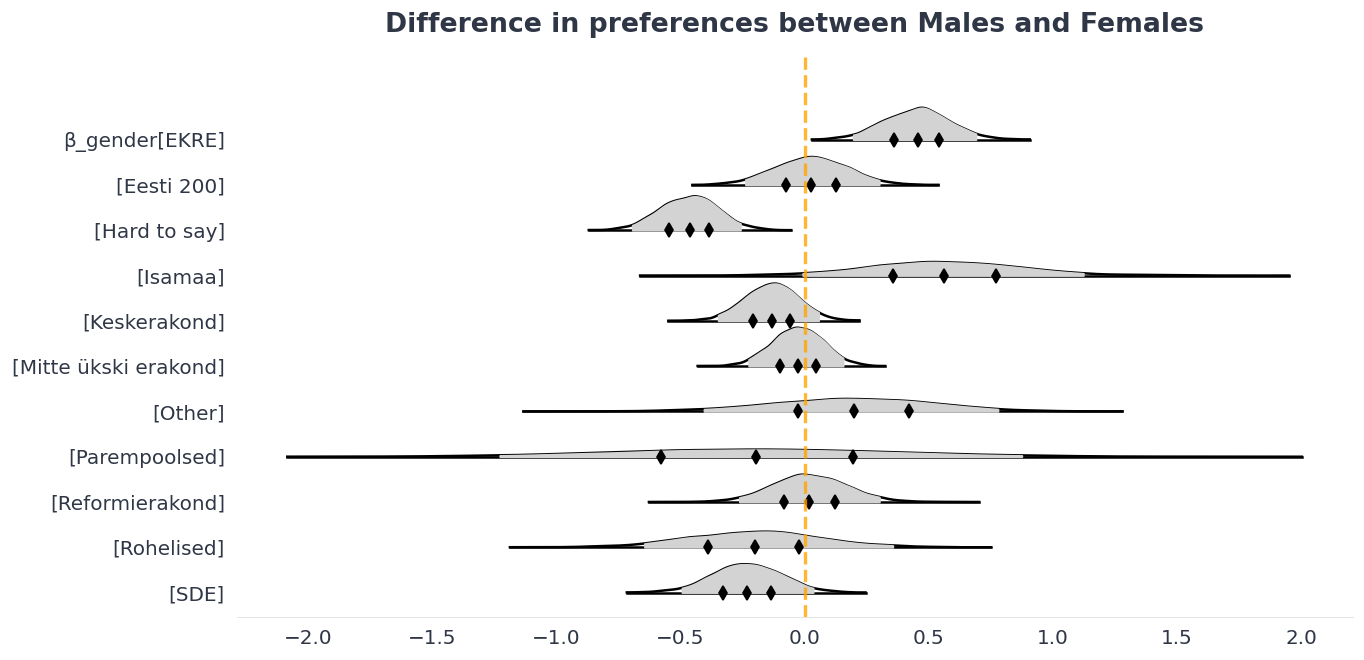

In [49]:
ax = az.plot_forest(
    gender_diff,
    combined=True,
    kind="ridgeplot",
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    ridgeplot_overlap=0.7,
    colors="lightgrey",
)
ax[0].axvline(ls="--", alpha=0.8, color="orange", lw=2);
ax[0].set(title="Difference in preferences between Males and Females")
plt.show()

### notes
* males and females have similar preferences for most parties
* there are parties where the variance is big (e.g., Parempoolsed, Hard to say)
* Females are more indecisive (Hard to say)
* Males prefer EKRE
* there is also an effect of `gender` captured by the interaction term (between gender and nationality)

## correlation of `nationality` with voting preferences
* heatmap of posterior medians of `β_nationality`, with nationality horizontally and parties vertically.

In [52]:
median_nat_df = (
    multinomial_idata
        .posterior["β_nationality"]  # (chain, draw, nationality, party)
        .median(dim=("chain", "draw"))
        .to_dataframe()
        .reset_index()
        .pivot(index="party", columns="nationality", values="β_nationality")
)

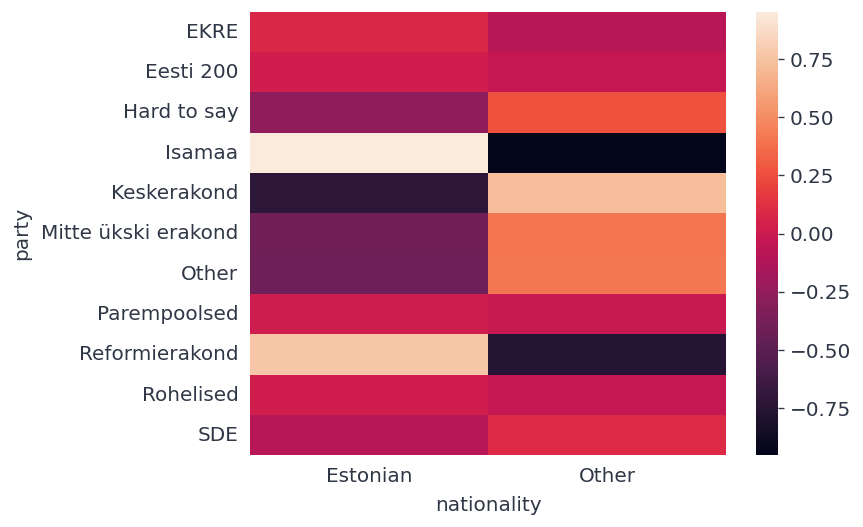

In [53]:
sns.heatmap(median_nat_df)
plt.show()

In [54]:
median_nat_df

nationality          Estonian     Other
party                                  
EKRE                 0.089125 -0.089125
Eesti 200            0.024598 -0.024598
Hard to say         -0.261385  0.261385
Isamaa               0.953283 -0.953283
Keskerakond         -0.722738  0.722738
Mitte ükski erakond -0.403636  0.403636
Other               -0.415758  0.415758
Parempoolsed         0.010581 -0.010581
Reformierakond       0.764994 -0.764994
Rohelised            0.024511 -0.024511
SDE                 -0.091452  0.091452

### Notes
* Estonians prefer Isamaa, Reformierakond
* Russians prefer Keskerakond, Mitte ükski erakond, Other
    * Russains are more indecisive

### Difference Between Nationalities

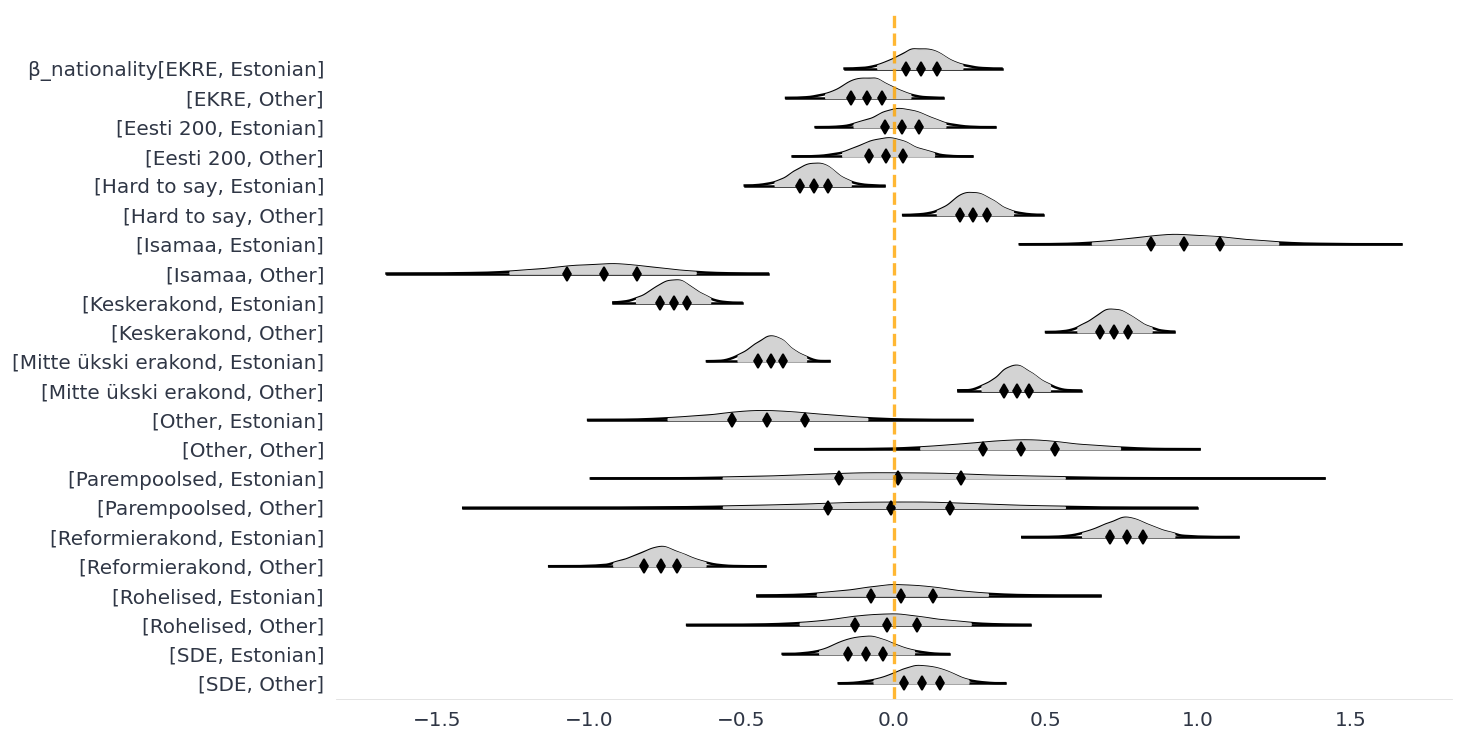

In [55]:
ax = az.plot_forest(
    multinomial_idata.posterior["β_nationality"].T,
    combined=True,
    kind="ridgeplot",
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    ridgeplot_overlap=0.7,
    colors="lightgrey",
)
ax[0].axvline(ls="--", alpha=0.8, color="orange", lw=2);

In [58]:
# multinomial_idata.posterior["β_nationality"].sel(

In [60]:
nationality_diff = (
    multinomial_idata.posterior["β_nationality"].sel(nationality="Estonian") - 
    multinomial_idata.posterior["β_nationality"].sel(nationality="Other")
)

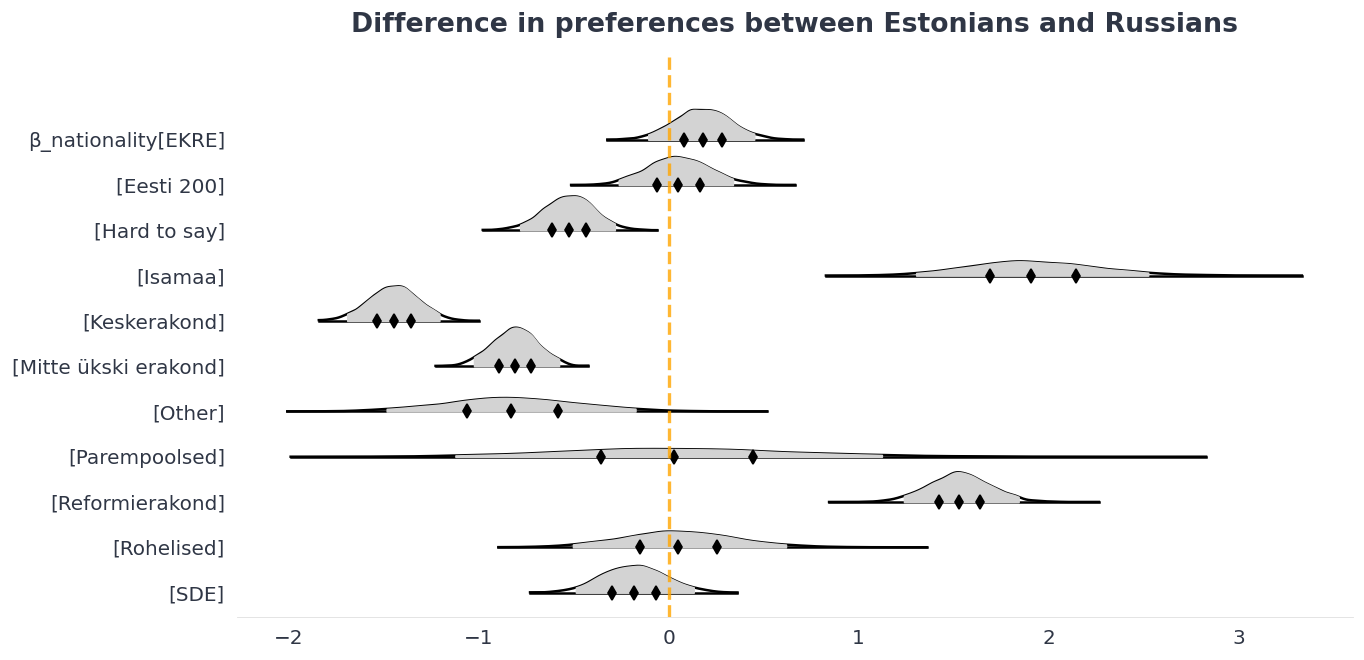

In [61]:
ax = az.plot_forest(
    nationality_diff,
    combined=True,
    kind="ridgeplot",
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    ridgeplot_overlap=0.7,
    colors="lightgrey",
)
ax[0].axvline(ls="--", alpha=0.8, color="orange", lw=2);
ax[0].set(title="Difference in preferences between Estonians and Russians")
plt.show()

### Mean behavior vs. Median Behavior (nationality)
* there is a large variance in Parempoolsed, Other and Isamaa
* here, concretely, we of course see the Estonian preference for Isamaa and Reformierakond, and the Russian preference for Keskerakond -- because they are the most obvious ones, so the medians pick them up.
* there is a slight Estonian preference for EKRE and Esti (but too small for the median), and a slight Russian preference for Mitte, Other and SDE. 
* Russians say they are more undecided than Estonians.

## correlation of `gender-nationality` with voting preferences
* heatmap of posterior medians of `gender-nationality`, with gender and nationality nationality horizontally
and parties vertically.

In [62]:
total_gender_nat_effect = (
    multinomial_idata.posterior["β_gender"]
    + multinomial_idata.posterior["β_nationality"]
    + multinomial_idata.posterior["β_gender_nat"]
).rename("gender_nat_effect")  # add value (column) name to convert to dataframe

In [63]:
gender_nat_median_df = (
    total_gender_nat_effect
        .median(dim=("chain", "draw"))
        .to_dataframe()
        .reset_index()
        .pivot(
            index="party",
            columns=["gender", "nationality"],
            values="gender_nat_effect")
)

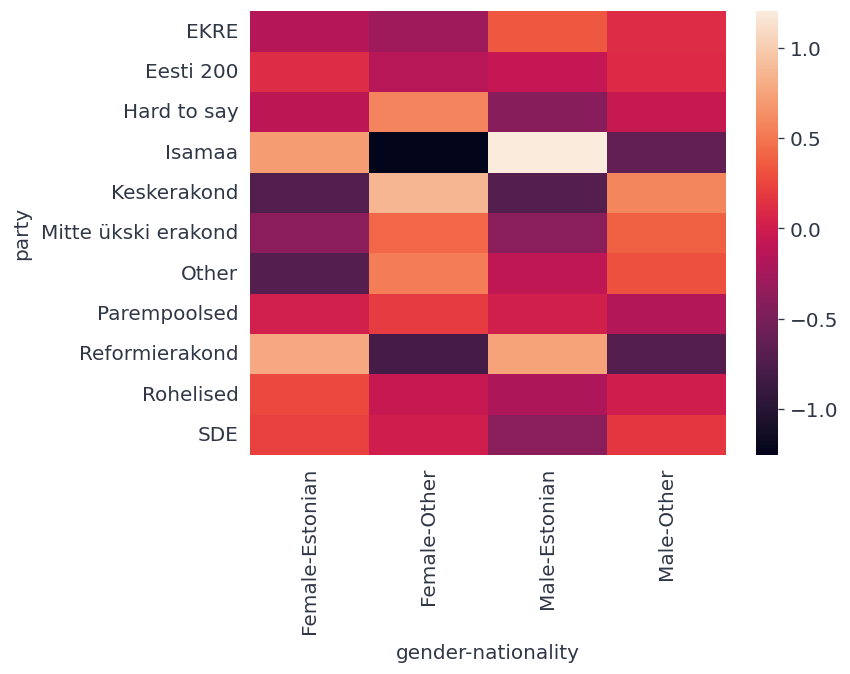

In [64]:
sns.heatmap(gender_nat_median_df)
plt.show()

In [65]:
(
    total_gender_nat_effect
        .median(dim=("chain", "draw"))
        .to_dataframe()
        .unstack(level=["gender", "nationality"])
        .droplevel(0, axis=1)
    # drop first column level: (gender_nat_effect, gender, nationality)
)

gender                 Female                Male          
nationality          Estonian     Other  Estonian     Other
party                                                      
EKRE                -0.164342 -0.286010  0.343344  0.109176
Eesti 200            0.116109 -0.143759 -0.064625  0.089765
Hard to say         -0.110818  0.571101 -0.414177 -0.046699
Isamaa               0.706895 -1.255298  1.203061 -0.631853
Keskerakond         -0.734072  0.863565 -0.712126  0.579522
Mitte ükski erakond -0.396173  0.424421 -0.409542  0.381630
Other               -0.717043  0.535544 -0.097575  0.304679
Parempoolsed         0.022630  0.203564  0.018413 -0.178545
Reformierakond       0.786495 -0.805934  0.743427 -0.723791
Rohelised            0.263770 -0.054656 -0.207678  0.009643
SDE                  0.221961  0.011611 -0.404037  0.172339

In [66]:
(
    total_gender_nat_effect
        .median(dim=("chain", "draw"))
        .to_dataframe()
        .unstack(level=["gender", "nationality"])
        .droplevel(0, axis=1)  
        .corr()
    # drop first column level: (gender_nat_effect, gender, nationality)
)

gender                Female                Male          
nationality         Estonian     Other  Estonian     Other
gender nationality                                        
Female Estonian     1.000000 -0.878619  0.718683 -0.893567
       Other       -0.878619  1.000000 -0.925275  0.842981
Male   Estonian     0.718683 -0.925275  1.000000 -0.856070
       Other       -0.893567  0.842981 -0.856070  1.000000

### Notes:
* we can see that there is a difference in behavior between the four groups

**11. *What are the median differences between the combinations?***

Let's look at Estonians.

**12. *Do a forest plot of the total gender effect for Estonians.***

### Difference between Estonian Females and Males:
* most of the coefficients are non-zeros
    * there is a signnificant difference between male in females in most parties (for the Estonians)

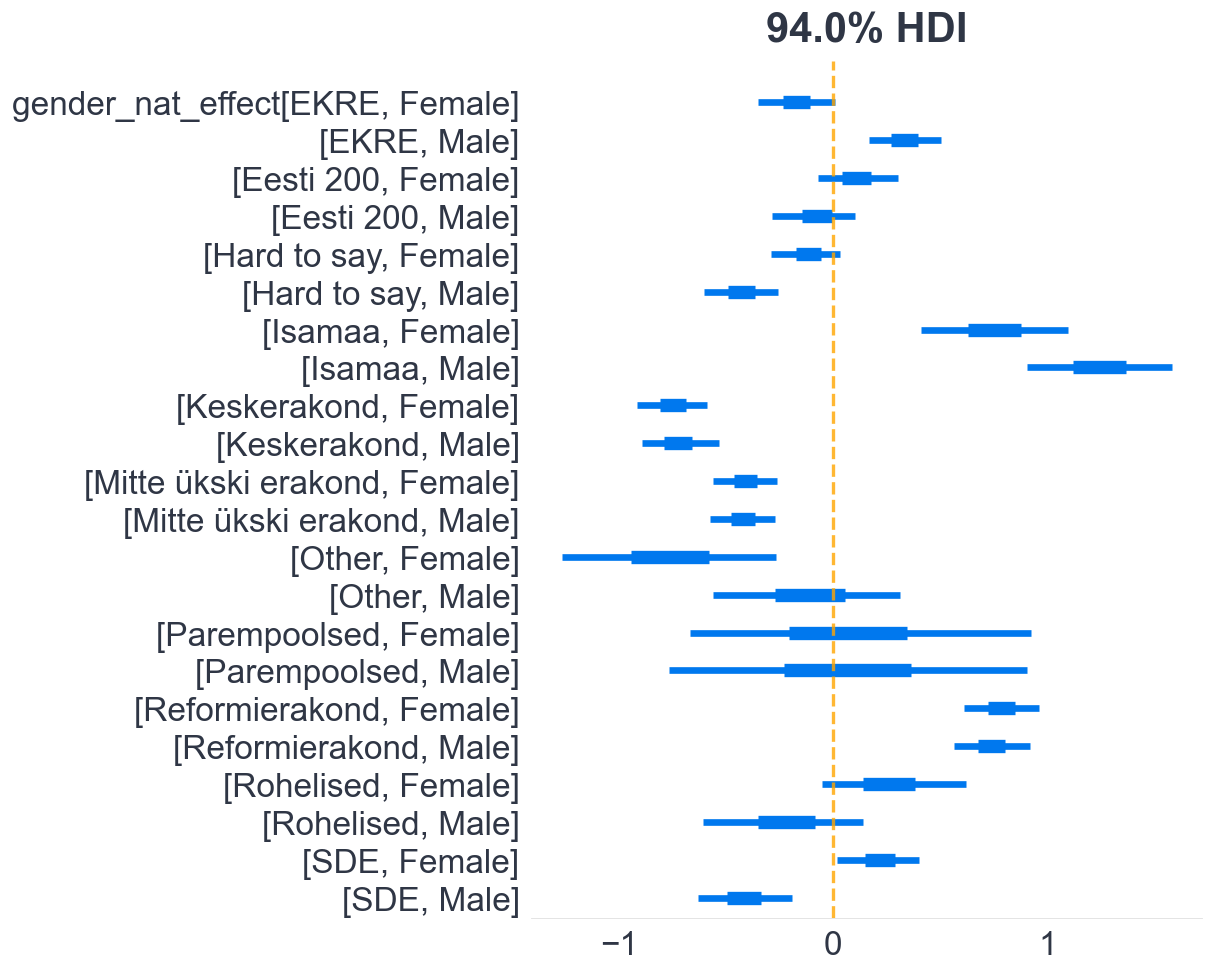

In [31]:
fig, ax = plt.subplots(figsize=(10, 8), layout="constrained")
az.plot_forest(
    total_gender_nat_effect.T,
    coords=dict(nationality="Estonian"),
    combined=True,
    ax=ax
);
ax.axvline(ls="--", alpha=0.8, color="orange", lw=2);

In [71]:
estonian_gender_diff = (
    total_gender_nat_effect.sel(gender="Male", nationality="Estonian") -
    total_gender_nat_effect.sel(gender="Female", nationality="Estonian")
)
russian_gender_diff = (
    total_gender_nat_effect.sel(gender="Male", nationality="Other") -
    total_gender_nat_effect.sel(gender="Female", nationality="Other")
)

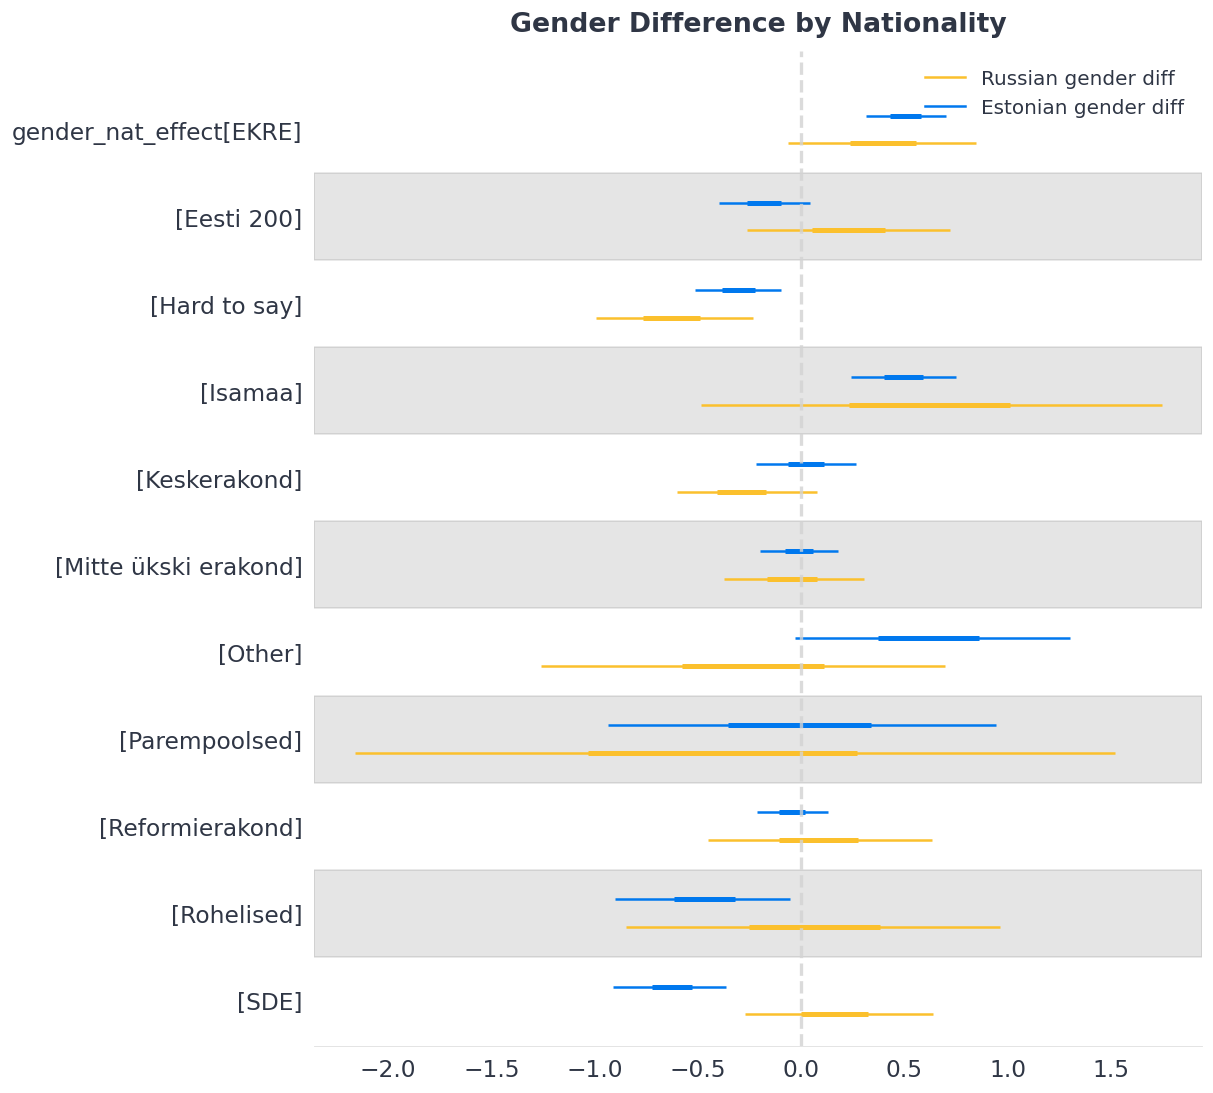

In [102]:
fig, ax = plt.subplots(figsize=(10, 9), layout="constrained")
az.plot_forest(
    data=[estonian_gender_diff, russian_gender_diff],
    model_names=["Estonian gender diff", "Russian gender diff"],
    combined=True,
    ax=ax
)
ax.axvline(ls="--", alpha=0.8, color="lightgray", lw=2)
ax.set(title="Gender Difference by Nationality")
plt.show()

### Note
* there is no significant differnce between the magnitude in difference between\
Males and Females in Estonia and Russia

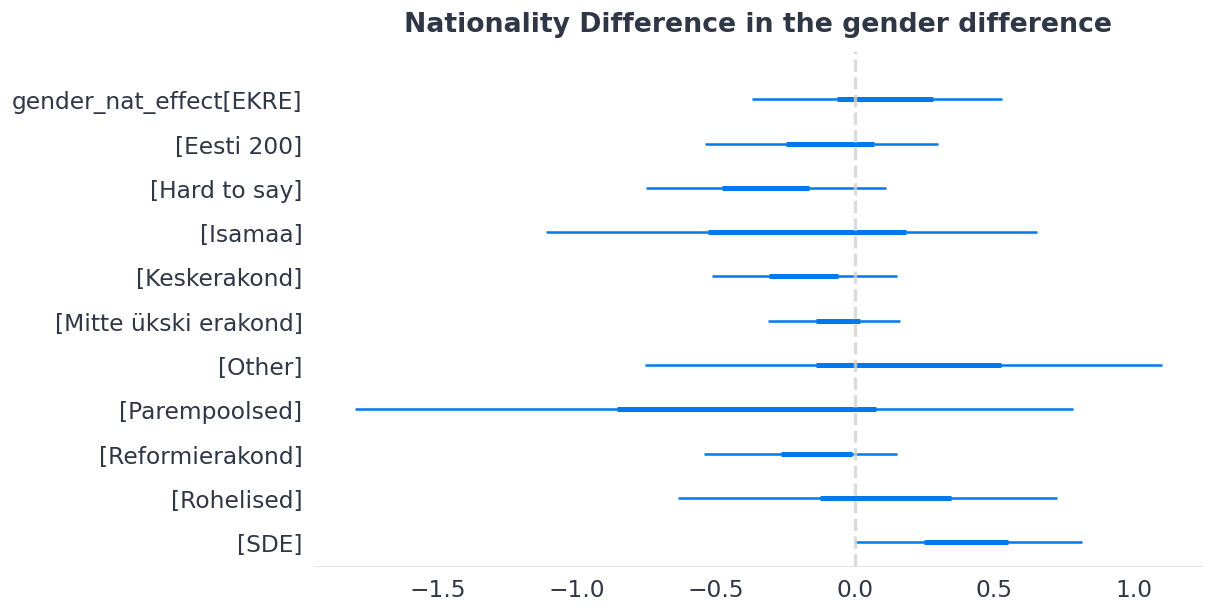

In [104]:
fig, ax = plt.subplots(figsize=(10, 5), layout="constrained")
az.plot_forest(
    data=np.abs(estonian_gender_diff) -  np.abs(russian_gender_diff),
    # model_names=["NatDifference in the gender difference gender diff", "Russian gender diff"],
    combined=True,
    ax=ax
)
ax.axvline(ls="--", alpha=0.8, color="lightgray", lw=2)
ax.set(title="Nationality Difference in the gender difference")
plt.show()

### Difference between Russian Females and Males:
* many of the coefficients are zeros
    * there is a less signnificant difference between male in females in most parties (for the Russians)

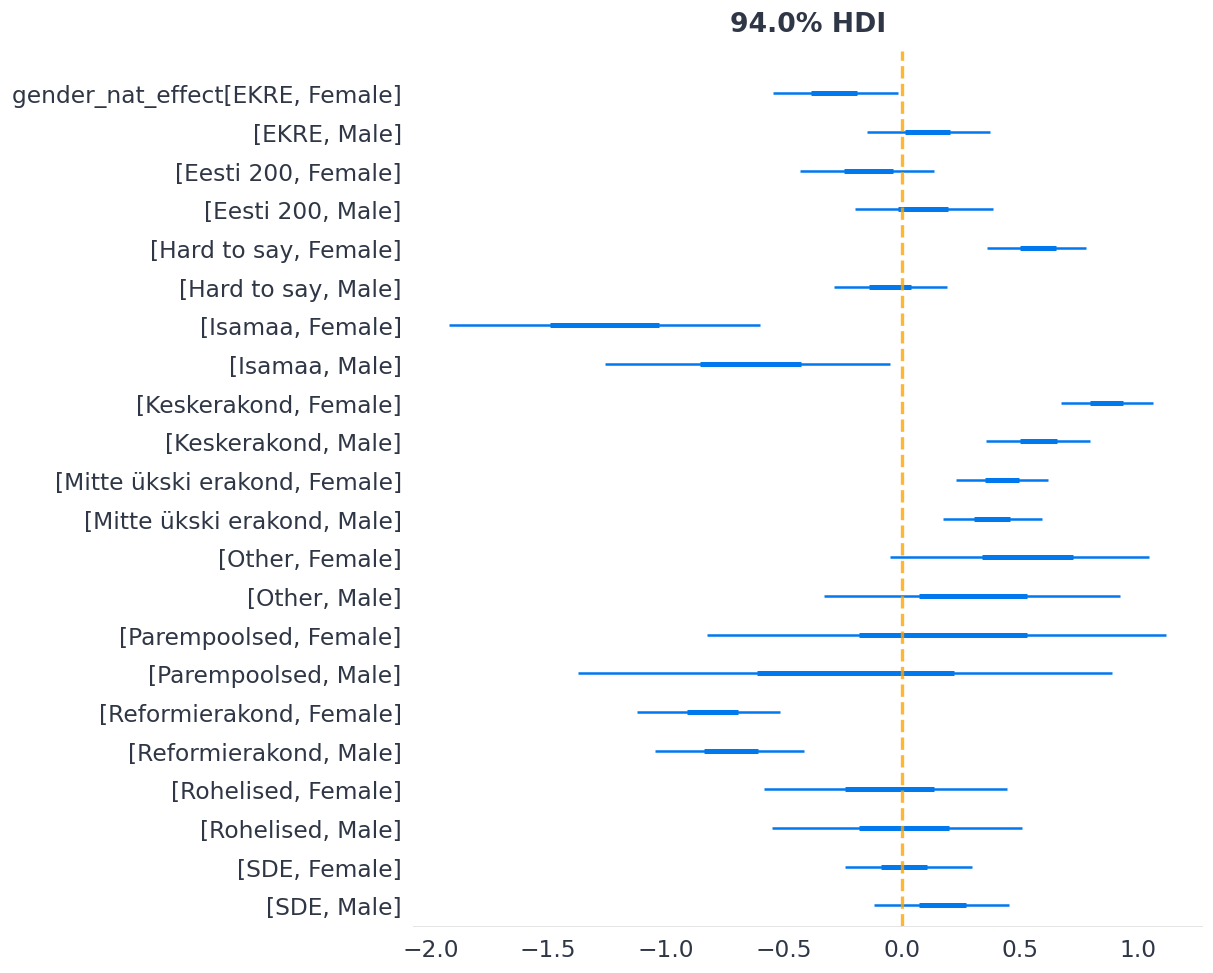

In [105]:
fig, ax = plt.subplots(figsize=(10, 8), layout="constrained")
az.plot_forest(
    total_gender_nat_effect.T,
    coords=dict(nationality="Other"),
    combined=True,
    ax=ax
);
ax.axvline(ls="--", alpha=0.8, color="orange", lw=2);

### Differences between Russian and Estonian Men
* Estonian men have a strong preference for EKRE, Isamaa and Reformierakond, while Russians favor the parties that Estonian men dislike most -- Keskerakond, Mitte and SDE.

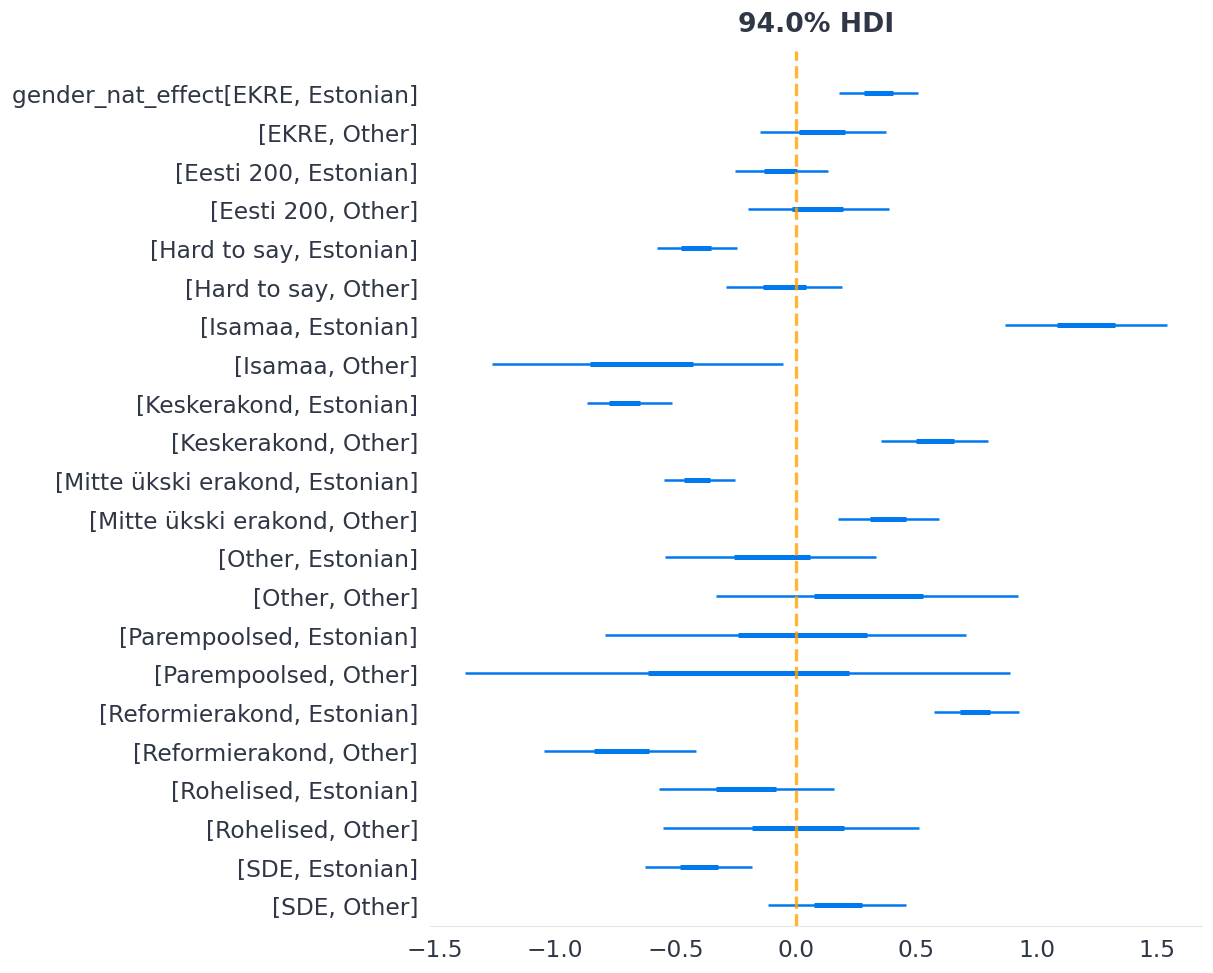

In [106]:
# Russian and Estonian men
fig, ax = plt.subplots(figsize=(10, 8), layout="constrained")
az.plot_forest(
    total_gender_nat_effect,
    coords=dict(gender="Male"),
    combined=True,
    ax=ax
);
ax.axvline(ls="--", alpha=0.8, color="orange", lw=2);

### Differences between Russian and Estonian Females
* Overall, there are many similar preferences between the Estonian females and the Russia females
* Estonian women have a strong preference for Isamaa Reformierakond, while Russians favor the parties that Estonian women dislike most -- Keskerakond, Mitte
    * Russian females are more indecisive (Other and Hard to say)

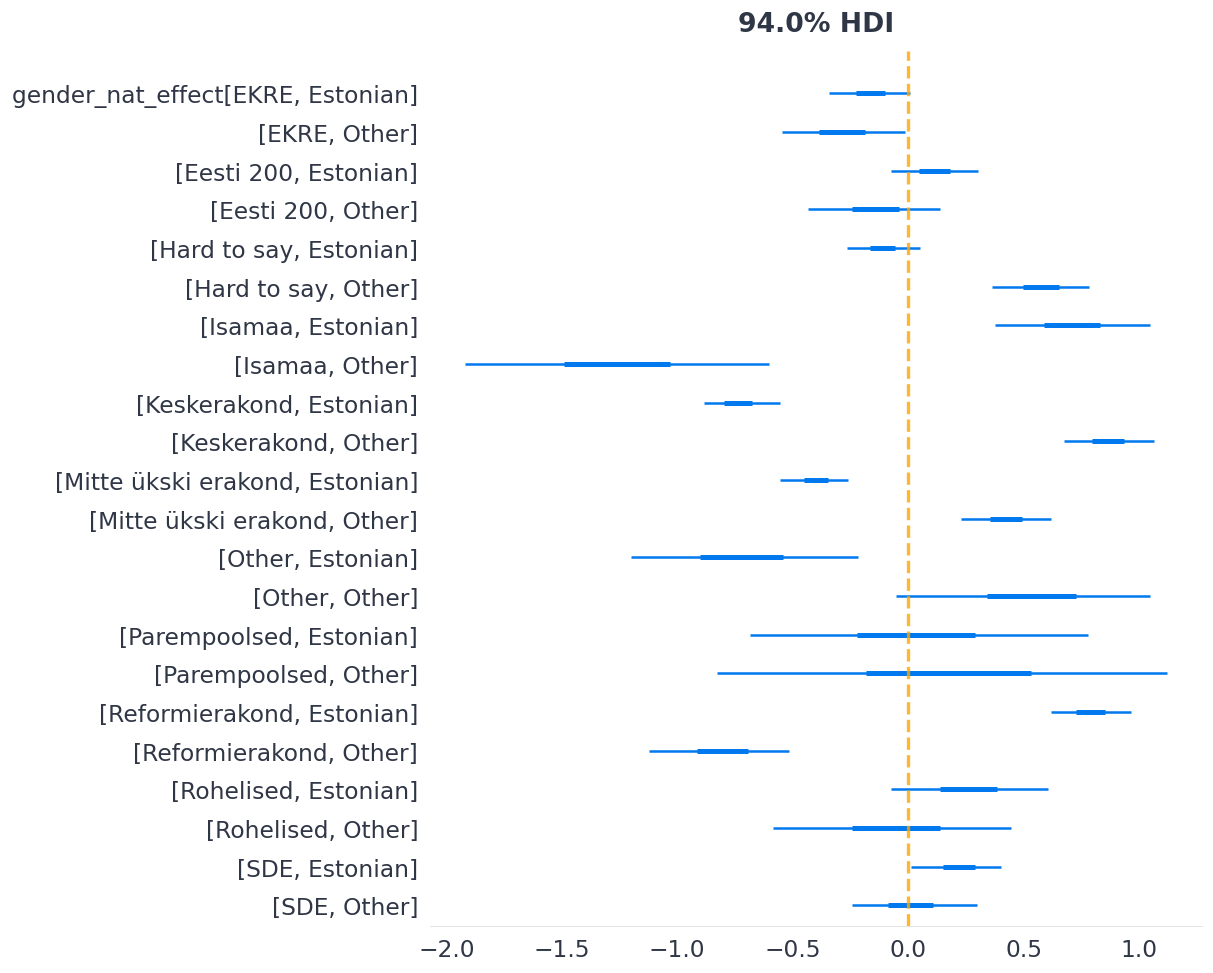

In [107]:
fig, ax = plt.subplots(figsize=(10, 8), layout="constrained")
az.plot_forest(
    total_gender_nat_effect,
    coords=dict(gender="Female"),
    combined=True,
    ax=ax
);
ax.axvline(ls="--", alpha=0.8, color="orange", lw=2);

# Stratum Analysis

* ArviZ `Multiindex`

In [108]:
observed_aggregated_answers = pd.read_csv("../data/observed_aggregated_answers.csv")

In [109]:
demographics_order = [
    "age_group",
    "education",
    "gender",
    "nationality",
    "electoral_district",
    "unit",
]

In [110]:
# create index coordinates using pandas multi-index (i.e., strata) in ArviZ
obs_idx_detailed = observed_aggregated_answers.set_index(demographics_order).index
idx_coords = xr.Coordinates.from_pandas_multiindex(
    midx=obs_idx_detailed,
    dim="obs_idx")


In [111]:
idx_coords

Coordinates:
  * obs_idx             (obs_idx) object MultiIndex
  * age_group           (obs_idx) object '16-24' '16-24' '16-24' ... '75+' '75+'
  * education           (obs_idx) object 'Basic education' ... 'Secondary edu...
  * gender              (obs_idx) object 'Female' 'Female' ... 'Male' 'Male'
  * nationality         (obs_idx) object 'Estonian' 'Estonian' ... 'Other'
  * electoral_district  (obs_idx) object 'Haabersti, Põhja-Tallinn ja Kristii...
  * unit                (obs_idx) object 'Haabersti' 'Kristiine' ... 'Pärnumaa'

Now we add the new coords (to `constant_data` as well, because we need it for plotting):

In [113]:
multinomial_idata.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, obs_idx: 1157, party: 11)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * obs_idx  (obs_idx) int64 0 1 2 3 4 5 6 ... 1151 1152 1153 1154 1155 1156
  * party    (party) <U19 'EKRE' 'Eesti 200' 'Hard to say' ... 'Rohelised' 'SDE'
Data variables:
    y        (chain, draw, obs_idx, party) int64 0 0 1 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    created_at:                 2023-12-17T13:34:54.595170
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0

In [114]:
# index prior/posterior predictive and constant_data (observed value)
multinomial_idata.prior_predictive = (
    multinomial_idata.prior_predictive.assign_coords(idx_coords)
)
multinomial_idata.posterior_predictive = (
    multinomial_idata.posterior_predictive.assign_coords(idx_coords)
)
multinomial_idata.constant_data = (
    multinomial_idata.constant_data.assign_coords(idx_coords)
)

And here is the `posterior_predictive` group after:

In [115]:
multinomial_idata.posterior_predictive

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 1000, party: 11, obs_idx: 1157)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * party               (party) <U19 'EKRE' 'Eesti 200' ... 'Rohelised' 'SDE'
  * obs_idx             (obs_idx) object MultiIndex
  * age_group           (obs_idx) object '16-24' '16-24' '16-24' ... '75+' '75+'
  * education           (obs_idx) object 'Basic education' ... 'Secondary edu...
  * gender              (obs_idx) object 'Female' 'Female' ... 'Male' 'Male'
  * nationality         (obs_idx) object 'Estonian' 'Estonian' ... 'Other'
  * electoral_district  (obs_idx) object 'Haabersti, Põhja-Tallinn ja Kristii...
  * unit                (obs_idx) object 'Haabersti' 'Kristiine' ... 'Pärnumaa'
Data variables:
    y                   (chain, draw, obs_idx, party) int64 0 0 1 0 ... 0 0 0 0
Attributes:
    created_at:                 2023-12-17T13:34:54.595170
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0

### posterior retrodictive voting intentions of Estonians in the electoral district "Haabersti, Põhja-Tallinn ja Kristiine"

In [116]:
strata_dict = dict(
    nationality="Estonian",
    electoral_district='Haabersti, Põhja-Tallinn ja Kristiine'
)
strata_dict

{'nationality': 'Estonian',
 'electoral_district': 'Haabersti, Põhja-Tallinn ja Kristiine'}

In [117]:
# DataArray of the size of the strata
strata_size = multinomial_idata.constant_data["N"].sel(strata_dict).sum("obs_idx")
strata_size

<xarray.DataArray 'N' ()>
array(393)
Coordinates:
    nationality         <U8 'Estonian'
    electoral_district  <U37 'Haabersti, Põhja-Tallinn ja Kristiine'

In [118]:
# analysis for Estoninan in 'Haabersti, Põhja-Tallinn ja Kristiine' electoral district
# posterior proportion samples of parties
est_haabersti_posterior_prop = az.extract(
    (multinomial_idata
         .posterior_predictive
         .sel(indexers=strata_dict)
         .sum(dim="obs_idx")) 
    / strata_size
    )["y"] * 100
est_haabersti_posterior_prop

<xarray.DataArray 'y' (party: 11, sample: 4000)>
array([[10.17811705,  9.92366412,  8.65139949, ..., 11.95928753,
         8.65139949,  6.61577608],
       [ 9.41475827, 12.97709924, 10.17811705, ...,  9.6692112 ,
        16.79389313, 15.01272265],
       [11.45038168,  9.41475827, 10.17811705, ..., 11.45038168,
        10.43256997, 11.70483461],
       ...,
       [29.26208651, 26.46310433, 27.2264631 , ..., 31.043257  ,
        27.48091603, 26.46310433],
       [ 3.56234097,  3.30788804,  1.27226463, ...,  4.32569975,
         2.54452926,  1.0178117 ],
       [ 6.87022901,  8.65139949,  8.90585242, ...,  7.37913486,
         8.65139949,  7.37913486]])
Coordinates:
  * party               (party) <U19 'EKRE' 'Eesti 200' ... 'Rohelised' 'SDE'
    nationality         <U8 'Estonian'
    electoral_district  <U37 'Haabersti, Põhja-Tallinn ja Kristiine'
  * sample              (sample) object MultiIndex
  * chain               (sample) int64 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
  * draw                (sample) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999

In [119]:
# prior proportion samples of parties
est_haabersti_prior_prop = az.extract(
    (multinomial_idata
         .prior_predictive
         .sel(indexers=strata_dict)
         .sum(dim="obs_idx")) 
    / strata_size
    )["y"] * 100
est_haabersti_prior_prop

<xarray.DataArray 'y' (party: 11, sample: 500)>
array([[24.17302799,  3.56234097, 20.86513995, ...,  2.29007634,
         7.37913486, 11.19592875],
       [ 5.8524173 ,  8.39694656,  9.16030534, ..., 27.73536896,
         0.76335878,  1.52671756],
       [ 1.52671756,  3.81679389, 10.6870229 , ...,  3.05343511,
        22.64631043,  6.61577608],
       ...,
       [26.97201018,  1.78117048,  0.25445293, ..., 20.61068702,
         1.27226463,  0.50890585],
       [ 1.52671756,  0.25445293, 18.06615776, ...,  5.34351145,
         7.88804071,  0.50890585],
       [12.72264631, 33.58778626,  2.79898219, ..., 23.15521628,
         0.50890585,  2.79898219]])
Coordinates:
  * party               (party) <U19 'EKRE' 'Eesti 200' ... 'Rohelised' 'SDE'
    nationality         <U8 'Estonian'
    electoral_district  <U37 'Haabersti, Põhja-Tallinn ja Kristiine'
  * sample              (sample) object MultiIndex
  * chain               (sample) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * draw                (sample) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499

In [120]:
est_haabersti_observed_prop = (
    multinomial_idata
        .constant_data
        .sel(indexers=strata_dict)
        .sum("obs_idx")["observed"]
    / strata_size
) * 100
est_haabersti_observed_prop

<xarray.DataArray (party: 11)>
array([10.43256997, 13.48600509,  8.39694656,  7.12468193,  5.8524173 ,
       11.95928753,  1.27226463,  0.25445293, 28.75318066,  2.79898219,
        9.6692112 ])
Coordinates:
  * party               (party) <U19 'EKRE' 'Eesti 200' ... 'Rohelised' 'SDE'
    nationality         <U8 'Estonian'
    electoral_district  <U37 'Haabersti, Põhja-Tallinn ja Kristiine'

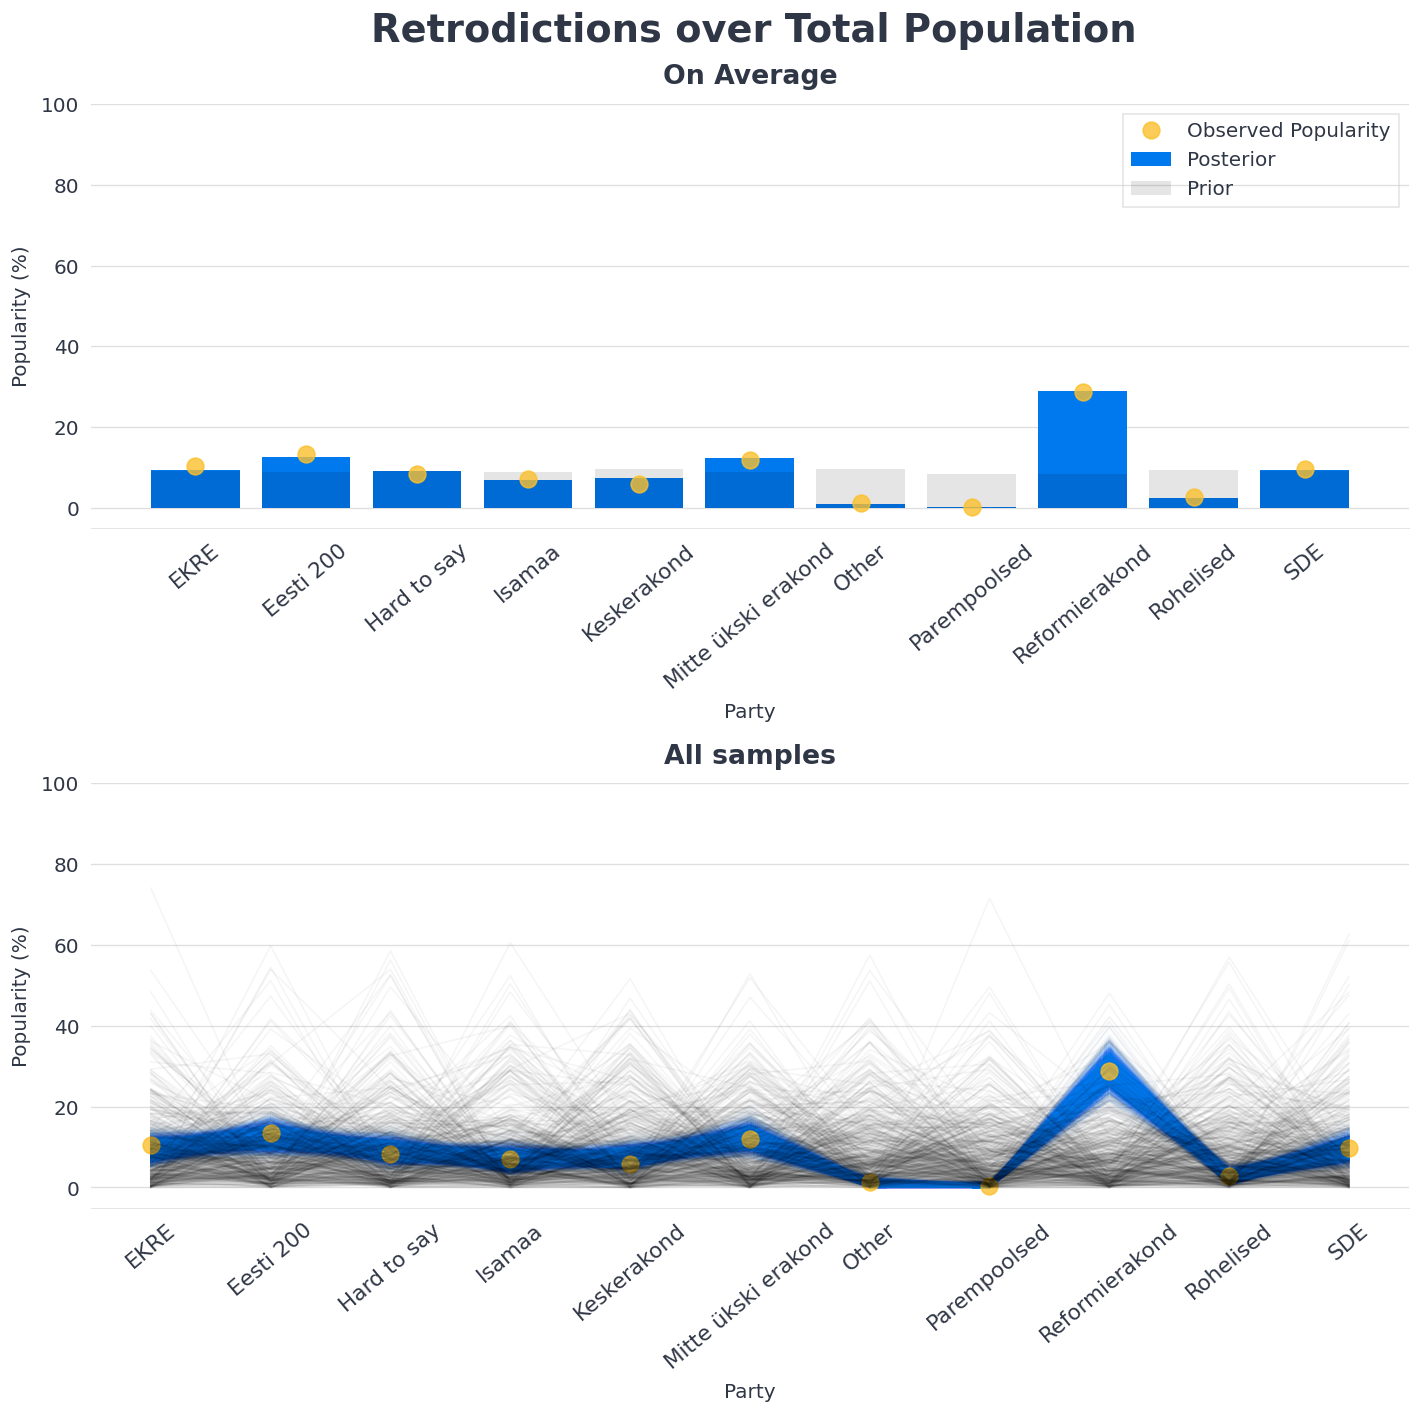

In [121]:
_, (ax_bar, ax_line) = plt.subplots(2, 1, figsize=(12, 12), sharey=True)
ax_bar.bar(
    PARTIES, 
    est_haabersti_posterior_prop.mean("sample").round(2), 
    label="Posterior")
ax_bar.plot(
    PARTIES,
    est_haabersti_observed_prop,
    "o",
    ms=10,
    label="Observed Popularity",
    color="#fbc02d",
    alpha=0.8,
)
ax_bar.bar(
    PARTIES,
    est_haabersti_prior_prop.mean("sample").round(2),
    label="Prior",
    color="black",
    alpha=0.1,
)
ax_bar.set(title="On Average", xlabel="Party", ylabel="Popularity (%)")
ax_bar.set_xticks(range(len(PARTIES)), PARTIES, fontsize=13, rotation=40)
ax_bar.legend(fontsize=12, frameon=True)

ax_line.plot(PARTIES, est_haabersti_posterior_prop, color="#0078ee", alpha=0.01, lw=1)
ax_line.plot(PARTIES, est_haabersti_observed_prop, "o", ms=10, color="#fbc02d", alpha=0.8)
ax_line.plot(PARTIES, est_haabersti_prior_prop, color="black", alpha=0.04, lw=1)
ax_line.set(title="All samples", xlabel="Party", ylabel="Popularity (%)", ylim=(-5, 100))
ax_line.set_xticks(range(len(PARTIES)), PARTIES, fontsize=13, rotation=40)

plt.suptitle("Retrodictions over Total Population", x=0.53, fontsize=23)
plt.tight_layout()
plt.show()

In [122]:
est_haabersti_pred_prop = (
    multinomial_idata
        .posterior_predictive
         .sel(indexers=strata_dict)
         .sum(dim="obs_idx") 
        / strata_size
)["y"] * 100

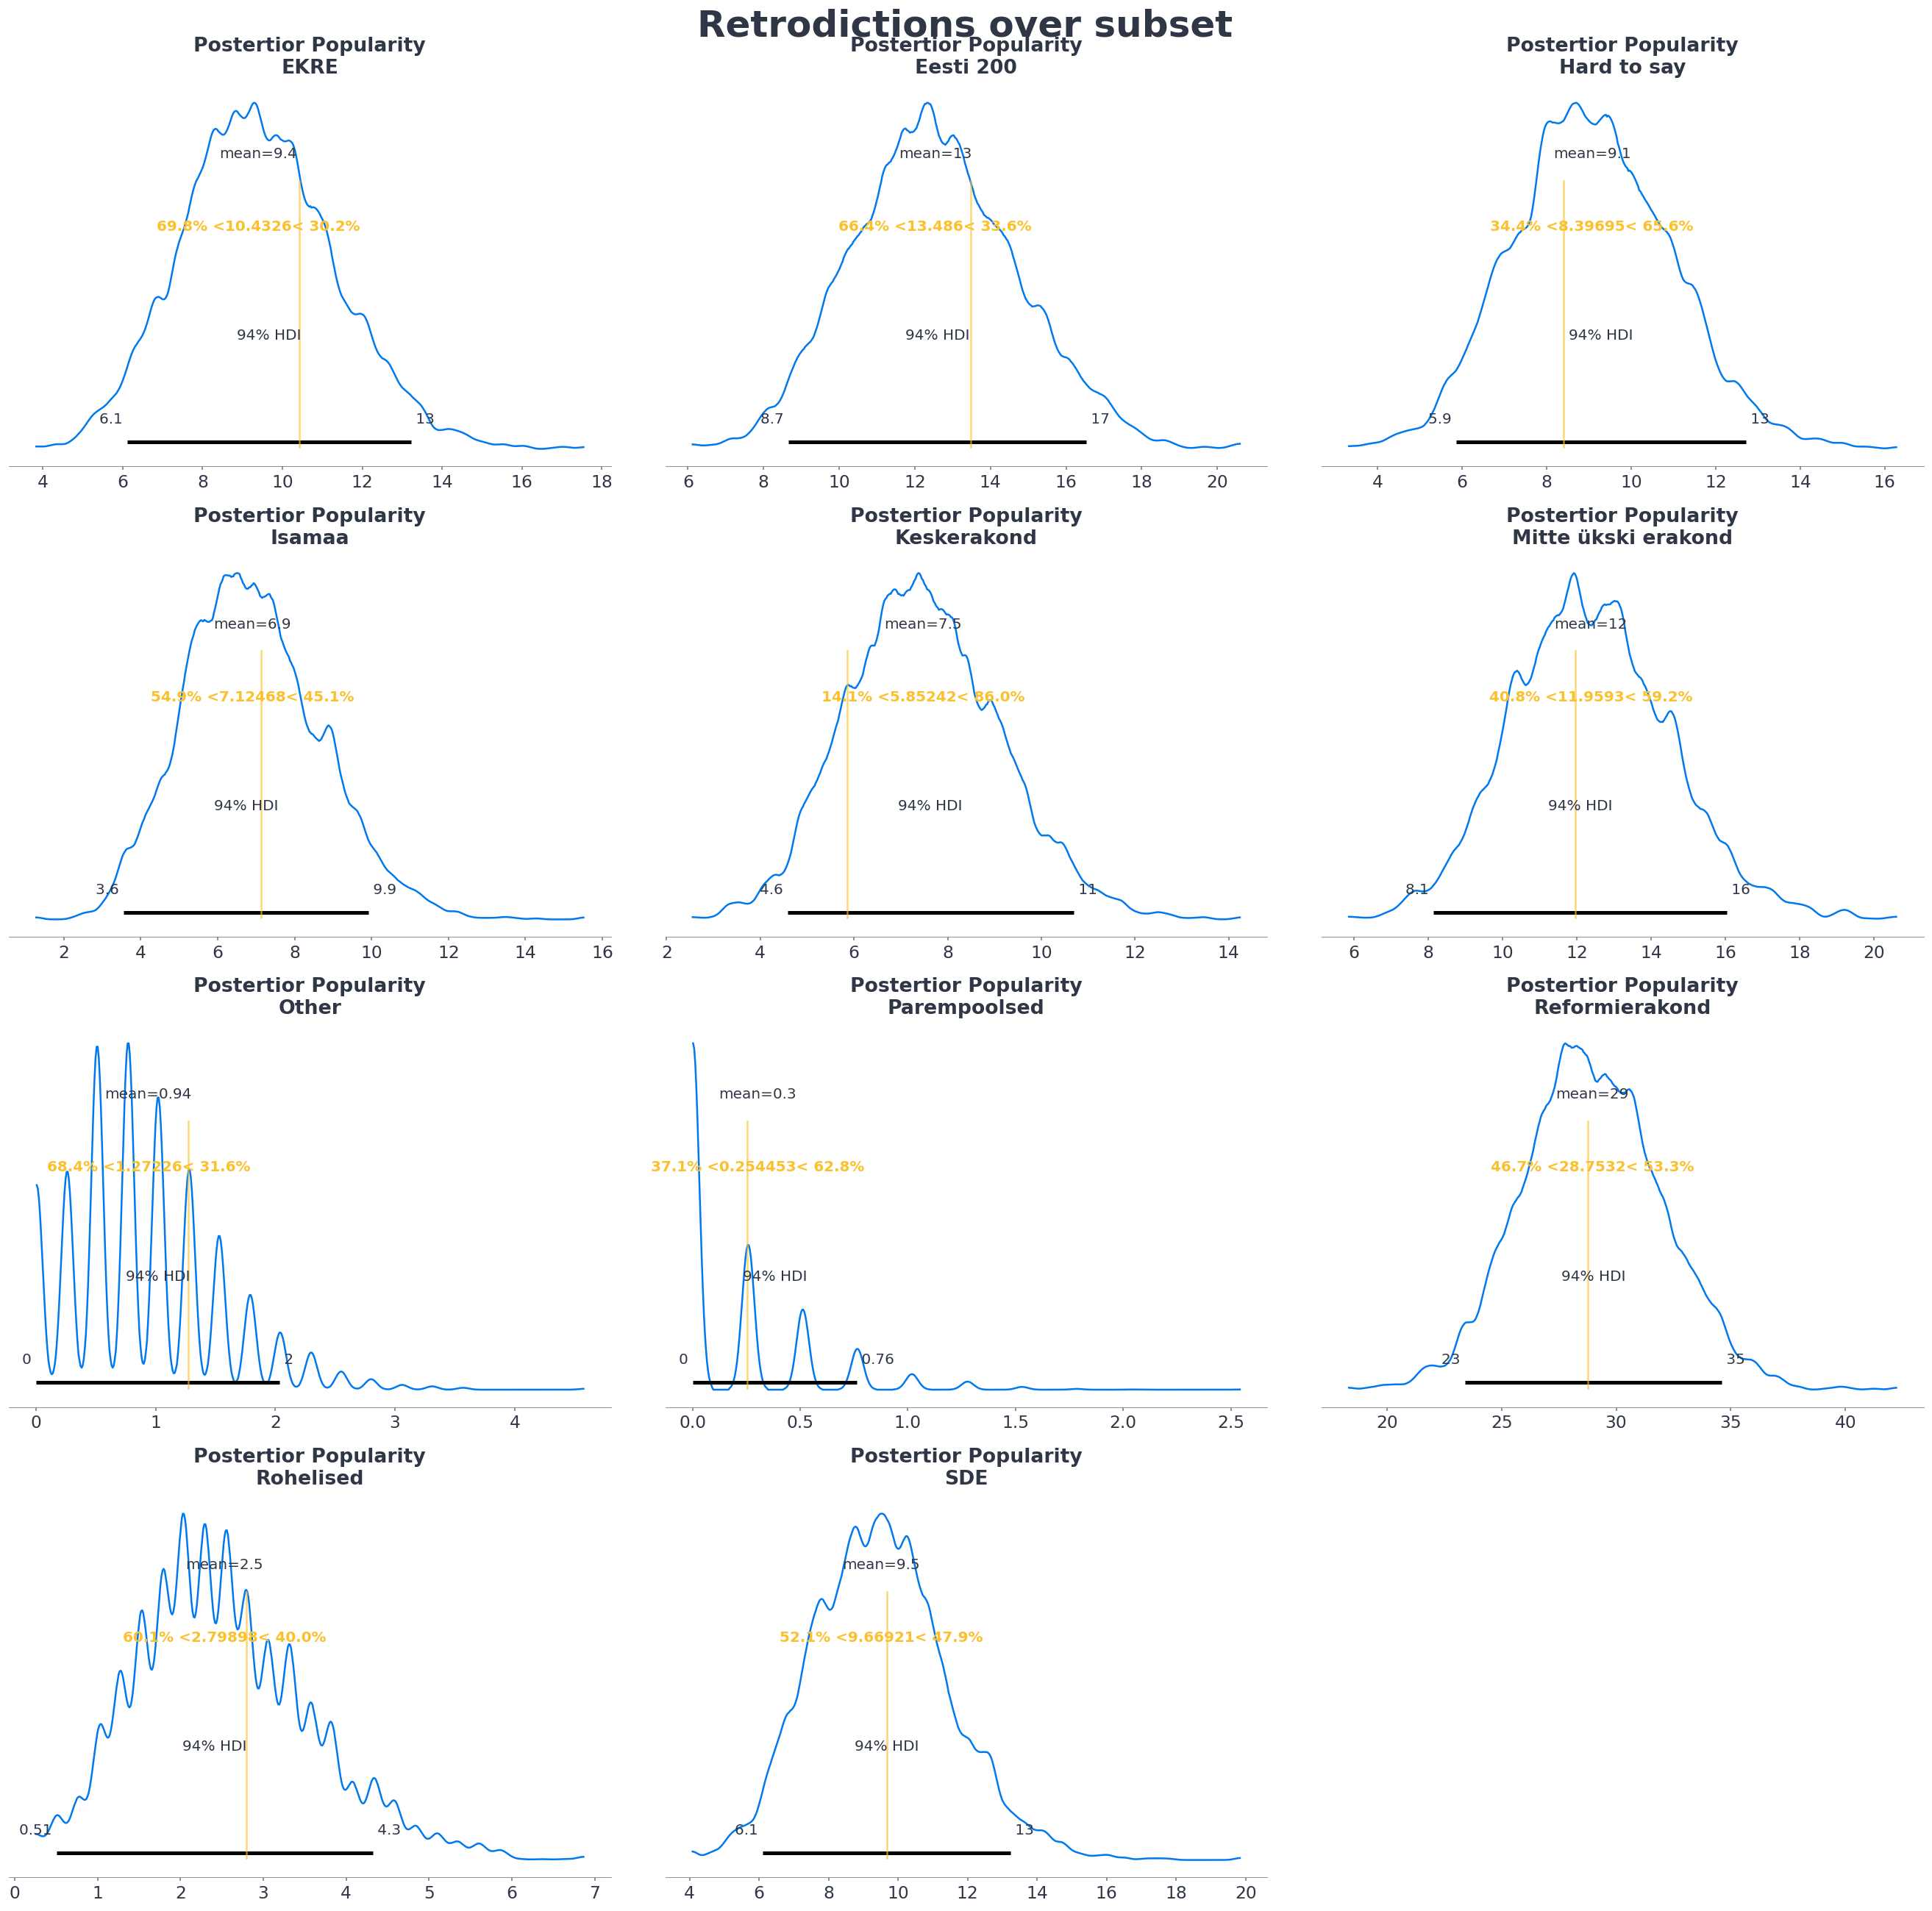

In [123]:
_ = az.plot_posterior(
    data=est_haabersti_pred_prop.rename("Postertior Popularity"),
    ref_val=est_haabersti_observed_prop.to_numpy().tolist()
)
plt.suptitle("Retrodictions over subset", fontsize=30)
plt.tight_layout()